In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import seaborn
import os
import pandas as pd
import torchvision.transforms as transforms
import torchvision.models as models
import pickle
from statistics import mean
import torch.nn as nn 
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Dataset
from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, binarize_std, normalize_0to1
from interpretability_methods.vanilla_gradients import VanillaGradients
from interpretability_methods.gradcam import GradCAM

In [4]:
class CelebADataset(CelebA):
    def __init__(self, root, split, image_transform = None, ground_truth_transform = None, ground_truth_type = "mouth"):
        super().__init__(root, split, ["attr", "landmarks"], transform=None, download = True)
        self.root = root
        self.image_transform = image_transform
        self.ground_truth_transform = ground_truth_transform
        self.ground_truth_type = ground_truth_type
        
    def __getitem__(self, idx):
        image, _ = super().__getitem__(idx)
        # 8 = black hair, 9 = blond hair, 31 = smiling
        attributes = self.attr[idx].numpy()
        black_hair = attributes[8]
        blond_hair = attributes[9]
        smiling = attributes[31]
        ground_truth = torch.tensor([])
        
        # if training, don't compute the ground truth
        if self.split == 'test':
            if self.ground_truth_type == "hair":
                # getting the ground truth at hair
                hq_mapping = pd.read_csv(self.root + "celeba/CelebA-HQ-to-CelebA-mapping.txt", delimiter="\s+", engine="python", header=0)
                map_row = hq_mapping.index[hq_mapping['orig_file'] == self.filename[idx]].tolist()
                if len(map_row) > 0:
                    hq_idx = int(hq_mapping.iloc[map_row]['idx'])  
                    ground_truth = self._create_ground_truth_hair(hq_idx)
            else:
                # getting the ground truth at mouth
                ground_truth = self._create_ground_truth_mouth(image, idx)
            
            # if ground truth was computed and transform exists:
            if ground_truth.numel() and self.ground_truth_transform is not None:
                ground_truth = self.ground_truth_transform(ground_truth).squeeze(0)
            
        if self.image_transform is not None:
            image = self.image_transform(image)
            
        return image, ground_truth, black_hair, blond_hair, smiling
    
    def _create_ground_truth_hair(self, hq_idx):
        """Creates a binary groudn truth mask based on the ImageNet annotations."""
        # getting idx of celeba-hq                                       
        folder = ""
        if hq_idx < 2000:
            folder = "0"
        elif 2000 <= hq_idx < 4000:
            folder = "1"
        elif 4000 <= hq_idx < 6000:
            folder = "2"
        elif 6000 <= hq_idx < 8000:
            folder = "3"
        elif 8000 <= hq_idx < 10000:
            folder = "4"
        elif 10000 <= hq_idx < 12000:
            folder = "5"
        elif 12000 <= hq_idx < 14000:
            folder = "6"
        elif 14000 <= hq_idx < 16000:
            folder = "7"
        elif 16000 <= hq_idx < 18000:
            folder = "8"
        elif 18000 <= hq_idx < 20000:
            folder = "9"
        elif 20000 <= hq_idx < 22000:
            folder = "10"
        elif 22000 <= hq_idx < 24000:
            folder = "11"
        elif 24000 <= hq_idx < 26000:
            folder = "12"
        elif 26000 <= hq_idx < 28000:
            folder = "13"
        elif 28000 <= hq_idx < 30000:
            folder = "14"
        folder += "/"
        mask_file = self.root + 'celeba/CelebAMask-HQ-mask-anno/' + folder + f"{hq_idx:05}" + "_hair.png"
        if (os.path.exists(mask_file)):
            mask_image = Image.open(mask_file)
            to_tensor = transforms.Compose([transforms.ToTensor(),])
            ground_truth = to_tensor(mask_image)[0]
            
            data_path = os.path.abspath(self.root + 'celeba/hair_annotation/')
            with open(os.path.join(data_path, f"{hq_idx:05}" + "_hair.pickle"), "wb") as handle:
                pickle.dump(ground_truth, handle, protocol=pickle.HIGHEST_PROTOCOL)
        else:
            ground_truth = torch.tensor([])
        return ground_truth

    def _create_ground_truth_mouth(self, image, idx):
        """Creates a binary groudn truth mask based on the ImageNet annotations."""
        to_tensor = transforms.Compose([transforms.ToTensor(),])
        image_shape = to_tensor(image).shape
        height, width = int(image_shape[1]), int(image_shape[2])
        ground_truth = torch.zeros((height, width))
        
        # list of landmarks (last 4 are mouth coordinates)
        landmarks = self.landmarks_align[idx].numpy()
        
        left_x, left_y = int(landmarks[6]), int(landmarks[7])
        right_x, right_y = int(landmarks[8]), int(landmarks[9])
        height = round(((2/3) * (right_x - left_x))/2)
        left_y -= height
        right_y += height
        ground_truth[left_y:right_y, left_x:right_x] = 1
        
        return ground_truth

In [5]:
# general transforms
image_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor()])
ground_truth_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(256, Image.NEAREST),
                                             transforms.CenterCrop(224), transforms.ToTensor()])
reverse_image_transform = transforms.Compose([transforms.ToPILImage(),])

In [6]:
celeba_dir = '' # TODO: add your celeba directory here.
train_dataset = CelebADataset(celeba_dir, 'train', image_transform = image_transform, ground_truth_transform = ground_truth_transform)
# validation_dataset = CelebADataset(celeba_dir, 'valid', image_transform = image_transform, ground_truth_transform = ground_truth_transform)
test_dataset = CelebADataset(celeba_dir, 'test', image_transform = image_transform, ground_truth_transform = ground_truth_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|                                                                                                  | 0/19962 [00:00<?, ?it/s]

torch.Size([1, 224, 224])


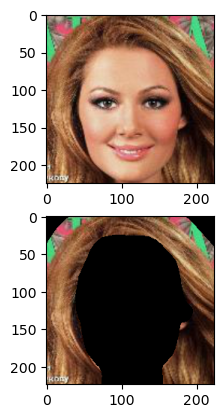

In [8]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
fig, ax = plt.subplots(2)
for batch_idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(test_loader)):
    # check if hair ground truth annotation exists 
    if (ground_truth.numel()):
        print (ground_truth.shape)
        masked_image_hair = image[0] * ground_truth[0]
        ax[0].imshow(image[0].permute(1,2,0))
        ax[1].imshow(reverse_image_transform(masked_image_hair))
        break

In [10]:
# setting seed for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
black_smiling = []
black_not_smiling = []
blond_smiling = []
blond_not_smiling = []

for idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(train_dataset):
    if black_hair and smiling:
        black_smiling.append(idx)
    elif black_hair and not smiling:
        black_not_smiling.append(idx)
    elif blond_hair and smiling:
        blond_smiling.append(idx)
    elif blond_hair and not smiling:
        blond_not_smiling.append(idx)

In [ ]:
# getting index of images of each group from test dataset

test_black_smiling = []
test_black_not_smiling = []
test_blond_smiling = []
test_blond_not_smiling = []

for idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(test_dataset):
    if len(ground_truth) > 0:
        if black_hair and smiling:
            test_black_smiling.append(idx)
        elif black_hair and not smiling:
            test_black_not_smiling.append(idx)
        elif blond_hair and smiling:
            test_blond_smiling.append(idx)
        elif blond_hair and not smiling:
            test_blond_not_smiling.append(idx)

In [11]:
# biased train dataset 
biased_train_black_smiling = random.sample(black_smiling, 10000)
biased_train_blond_not_smiling = random.sample(blond_not_smiling, 10000)

biased_train_black_not_smiling = random.sample(black_not_smiling, 100)
biased_train_blond_smiling = random.sample(blond_smiling, 100)
biased_train_samples = biased_train_black_smiling + biased_train_black_not_smiling + biased_train_blond_smiling + biased_train_blond_not_smiling
len(biased_train_samples)

20200

In [12]:
# unbiased train dataset
# get these from biased_samples (black smiling and blond not smiling) 
unbiased_train_black_smiling = random.sample(biased_train_black_smiling, 5000)
unbiased_train_blond_not_smiling = random.sample(biased_train_blond_not_smiling, 5000)

unbiased_train_black_not_smiling = biased_train_black_not_smiling + random.sample([k for k in black_not_smiling if k not in biased_train_black_not_smiling], 4900)
unbiased_train_blond_smiling = biased_train_blond_smiling + random.sample([k for k in blond_smiling if k not in biased_train_blond_smiling], 4900)
unbiased_train_samples = unbiased_train_black_smiling + unbiased_train_blond_not_smiling + unbiased_train_black_not_smiling + unbiased_train_blond_smiling
len(unbiased_train_samples)

20000

In [13]:
# biased test dataset
biased_test_black_smiling = random.sample(test_black_smiling, 1000)
biased_test_blond_not_smiling = random.sample(test_blond_not_smiling, 1000)

biased_test_black_not_smiling = random.sample(test_black_not_smiling, 100)
biased_test_blond_smiling = random.sample(test_blond_smiling, 100)
biased_test_samples = biased_test_black_smiling + biased_test_blond_not_smiling + biased_test_black_not_smiling + biased_test_blond_smiling
len(biased_test_samples)

2200

In [14]:
# unbiased test dataset
# get these from biased_samples (black smiling and blond not smiling) 
unbiased_test_black_smiling = random.sample(biased_test_black_smiling, 500)
unbiased_test_blond_not_smiling = random.sample(biased_test_blond_not_smiling, 500)

unbiased_test_black_not_smiling = biased_test_black_not_smiling + random.sample([k for k in test_black_not_smiling if k not in biased_test_black_not_smiling], 400)
unbiased_test_blond_smiling = biased_test_blond_smiling + random.sample([k for k in test_blond_smiling if k not in biased_test_blond_smiling], 400)
unbiased_test_samples = unbiased_test_black_smiling + unbiased_test_blond_not_smiling + unbiased_test_black_not_smiling + unbiased_test_blond_smiling
len(unbiased_test_samples)

2000

In [15]:
# unbiased test set with hair ground truth annotations
unbiased_hairtest_black_smiling = random.sample(test_hair_black_smile, 180)
unbiased_hairtest_blond_not_smiling = random.sample(test_hair_blond_not, 180)
unbiased_hairtest_black_not_smiling = random.sample(test_hair_black_not, 180)
unbiased_hairtest_blond_smiling = random.sample(test_hair_blond_smile, 180)
unbiased_hairtest_samples = unbiased_hairtest_black_smiling + unbiased_hairtest_blond_not_smiling + unbiased_hairtest_black_not_smiling + unbiased_hairtest_blond_smiling
len(unbiased_hairtest_samples)

720

In [16]:
biased_train = torch.utils.data.Subset(train_dataset, biased_train_samples)
unbiased_train = torch.utils.data.Subset(train_dataset, unbiased_train_samples)

In [17]:
biased_test = torch.utils.data.Subset(test_dataset, biased_test_samples)
unbiased_test = torch.utils.data.Subset(test_dataset, unbiased_test_samples)
unbiased_hairtest = torch.utils.data.Subset(hair_test_dataset, unbiased_hairtest_samples)

In [18]:
biased_train_loader = torch.utils.data.DataLoader(biased_train, batch_size=128, shuffle=True)
unbiased_train_loader = torch.utils.data.DataLoader(unbiased_train, batch_size=128, shuffle=True)

In [19]:
biased_test_loader = torch.utils.data.DataLoader(biased_test, batch_size=128, shuffle=True)
unbiased_test_loader = torch.utils.data.DataLoader(unbiased_test, batch_size=128, shuffle=True)
unbiased_hairtest_loader = torch.utils.data.DataLoader(unbiased_hairtest, batch_size=128, shuffle=True)

In [21]:
def binarize_threshold(batch, threshold):
    batch_normalized = normalize_0to1(batch)
    binary_mask = (batch_normalized >= threshold).astype('uint8')
    return binary_mask

In [22]:
def train(epoch, device, model, optimizer, train_loader):
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    loss_tot, correct, train_loss = 0, 0, 0
    for batch_idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(train_loader)):
        image = image.to(device)
        label = smiling.to(device)
        
        output = model(image)
        pred = torch.max(output, dim=-1)[1]
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (pred==label).sum().item()

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    print(f"Train Epoch: {epoch:0.01f} --- Loss: {train_loss:.05f}, Acc: {accuracy:.05f}")

In [23]:
def test(seed, model, device, test_loader, model_type, test_type):
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction="sum")
    saliency_method = GradCAM(model, model.layer4[2])
    test_loss = 0
    correct = 0
    total_shared_interest_scores = {'iou_coverage': np.array([]),
                                    'ground_truth_coverage': np.array([]),
                                    'saliency_coverage': np.array([]),}
    total_saliency_masks = np.array([[[]]])
    saliency_mean = 0
    saliency_std = 0
    with torch.no_grad():
        for batch_idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(test_loader)):
            image = image.to(device)
            ground_truth = ground_truth.numpy()
            label = smiling.to(device)

            output = model(image)
            pred = torch.max(output, dim=-1)[1]
            test_loss += criterion(output, label).item()
            correct += (pred==label).sum().item()
            
            saliency = flatten(saliency_method.get_saliency(image))
            saliency_masks = binarize_threshold(saliency, 0.5)
                        
            if batch_idx == 0: 
                total_saliency_masks = saliency_masks
            else:
                total_saliency_masks = np.concatenate((total_saliency_masks, saliency_masks))
                
            # Compute Shared Interest scores
            for score in total_shared_interest_scores:
                shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
                total_shared_interest_scores[score] = np.concatenate((total_shared_interest_scores[score], shared_interest_scores))

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(test_type + ' test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    print('IoU coverage: ' + str(mean(total_shared_interest_scores['iou_coverage'])))
    
    # data_dir = '' # TODO add data directory here if you want to save your ouptuts. 
    # data_path = os.path.abspath(data_dir + str(seed) + '/' + model_type + '/')
    # if not os.path.exists(data_path):
    #     os.makedirs(data_path)
    # with open(os.path.join(data_path, test_type + "_accuracy.pickle"), "wb") as handle:
    #     pickle.dump(accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # with open(os.path.join(data_path, test_type + "_shared_interest_scores.pickle"), "wb") as handle:
    #     pickle.dump(total_shared_interest_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # with open(os.path.join(data_path, test_type + "_saliency_masks.pickle"), "wb") as handle:
    #     pickle.dump(total_saliency_masks, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
def pointing_game(model, data_loader):
    saliency_method = GradCAM(model, model.layer4[2])
    salient_pixel_count = 0
    for i, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(data_loader)):
        with torch.no_grad():
            image = image.to(device)
            smiling = smiling.to(device)
            ground_truth = ground_truth.numpy()
        saliency = flatten(saliency_method.get_saliency(image))

        # iterate through all pixels 
        for i in range(saliency.shape[0]):
            saliency_batch = saliency[i]
            ground_truth_batch = ground_truth[i]
            pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
            point = ground_truth_batch[pixel[0], pixel[1]]

            # check if most salient feature is in ground truth 
            if point > 0:
                salient_pixel_count += 1
    return salient_pixel_count / len(data_loader.dataset)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unbiased_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)

optimizer = optim.Adam(unbiased_model.parameters(), 0.0001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,5,], gamma=0.2)

n_epochs = 10
for epoch in range(1, n_epochs + 1):
    train(epoch, device, unbiased_model, optimizer, unbiased_train_loader)
    scheduler.step()

test(seed, unbiased_model, device, unbiased_test_loader, 'unbiased', 'unbiased')
test(seed, unbiased_model, device, unbiased_hairtest_loader, 'unbiased', 'unbiased_hair')
test(seed, unbiased_model, device, biased_test_loader, 'unbiased', 'biased')

print(pointing_game(unbiased_model, unbiased_test_loader))
print(pointing_game(unbiased_model, unbiased_hairtest_loader))
print(pointing_game(unbiased_model, biased_test_loader))
    
# torch.save(unbiased_model.state_dict(), '/home/hbang/data/celeba_data/seeds/' + str(seed) + '/unbiased/model.pth')
# torch.save(optimizer.state_dict(), '/home/hbang/data/celeba_data/seeds/' + str(seed) + '/unbiased/optimizer.pth')

In [32]:
# if loading already trained models 
biased_model_path = '' # TODO add saved biased model path here.
biased_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
biased_model.load_state_dict(torch.load(biased_model_path))

unbiased_model_path = '' #TODO add saved unbiased model path here. 
unbiased_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
unbiased_model.load_state_dict(torch.load(unbiased_model_path))

<All keys matched successfully>

In [ ]:
test(0, unbiased_model, device, unbiased_test_loader, 'unbiased', 'unbiased')
test(0, unbiased_model, device, unbiased_hairtest_loader, 'unbiased', 'unbiased_hair')
test(0, unbiased_model, device, biased_test_loader, 'unbiased', 'biased')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.49s/it]


unbiased test set: Average loss: 0.4312, Accuracy: 1831/2000 (92%)
IoU coverage: 0.48035227995181795
Saliency Mean: 0.0800, Std: 0.1733


 50%|███████████████████████████████████████████████                                               | 3/6 [01:38<01:38, 32.79s/it]

In [129]:
# test each data group splits

test_black_smiling_dataset = torch.utils.data.Subset(test_dataset, biased_test_black_smiling)
test_black_not_smiling_dataset = torch.utils.data.Subset(test_dataset, biased_test_black_not_smiling)
test_blond_smiling_dataset = torch.utils.data.Subset(test_dataset, biased_test_blond_smiling)
test_blond_not_smiling_dataset = torch.utils.data.Subset(test_dataset, biased_test_blond_not_smiling)

test_black_smiling_loader = torch.utils.data.DataLoader(test_black_smiling_dataset, batch_size=64, shuffle=True)
test_black_not_smiling_loader = torch.utils.data.DataLoader(test_black_not_smiling_dataset, batch_size=64, shuffle=True)
test_blond_smiling_loader = torch.utils.data.DataLoader(test_blond_smiling_dataset, batch_size=64, shuffle=True)
test_blond_not_smiling_loader = torch.utils.data.DataLoader(test_blond_not_smiling_dataset, batch_size=64, shuffle=True)

test(seed, unbiased_model, device, test_black_smiling_loader, 'unbiased', "biased_black_smiling")
test(seed, unbiased_model, device, test_black_not_smiling_loader, 'unbiased', "biased_black_not_smiling")
test(seed, unbiased_model, device, test_blond_smiling_loader, 'unbiased', "biased_blond_smiling")
test(seed, unbiased_model, device, test_blond_not_smiling_loader, 'unbiased', "biased_blond_not_smiling")

test(seed, biased_model, device, test_black_smiling_loader, 'biased', "biased_black_smiling")
test(seed, biased_model, device, test_black_not_smiling_loader, 'biased', "biased_black_not_smiling")
test(seed, biased_model, device, test_blond_smiling_loader, 'biased', "biased_blond_smiling")
test(seed, biased_model, device, test_blond_not_smiling_loader, 'biased', "biased_blond_not_smiling")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


biased_black_smiling test set: Average loss: 0.4152, Accuracy: 923/1000 (92%)
IoU coverage: 0.13490512810346347
Saliency Mean: 0.1223, Std: 0.2134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s]


biased_black_not_smiling test set: Average loss: 0.5065, Accuracy: 91/100 (91%)
IoU coverage: 0.0832932027000543
Saliency Mean: 0.1059, Std: 0.1926


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s]


biased_blond_smiling test set: Average loss: 0.4696, Accuracy: 89/100 (89%)
IoU coverage: 0.14245157583512974
Saliency Mean: 0.1240, Std: 0.2162


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


biased_blond_not_smiling test set: Average loss: 0.3293, Accuracy: 926/1000 (93%)
IoU coverage: 0.10928403825027855
Saliency Mean: 0.1048, Std: 0.1920


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


biased_black_smiling test set: Average loss: 0.0080, Accuracy: 998/1000 (100%)
IoU coverage: 0.0009543557947530007
Saliency Mean: 0.1291, Std: 0.2151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s]


biased_black_not_smiling test set: Average loss: 4.7039, Accuracy: 10/100 (10%)
IoU coverage: 6.473888649115235e-05
Saliency Mean: 0.1043, Std: 0.1975


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s]


biased_blond_smiling test set: Average loss: 3.1975, Accuracy: 45/100 (45%)
IoU coverage: 0.0044843400165926195
Saliency Mean: 0.1206, Std: 0.2022


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]

biased_blond_not_smiling test set: Average loss: 0.0047, Accuracy: 998/1000 (100%)
IoU coverage: 0.002263342558038391
Saliency Mean: 0.1411, Std: 0.2248


[127, 221, 13, 190, 32]


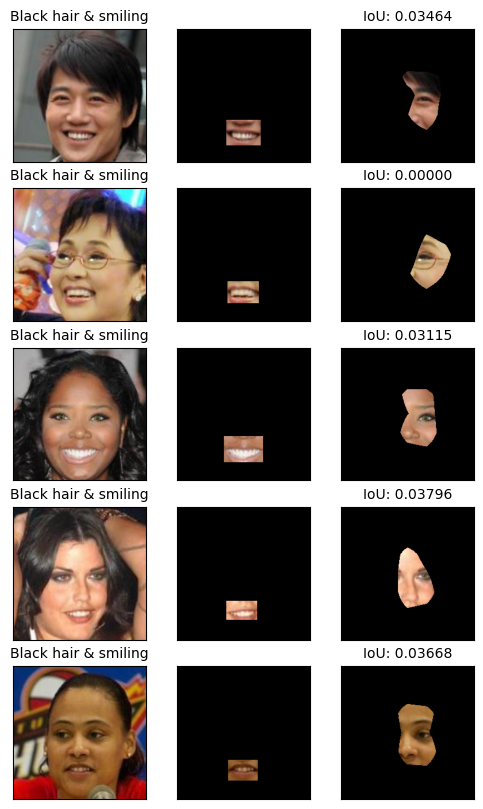

In [31]:
reverse_image_transform = transforms.Compose([transforms.ToPILImage(),])

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(6, 10))
np.vectorize(ax_off)(ax)
fig_images = random.sample(range(500), 5)
print (fig_images)

model_type = 'unbiased'
data_type = 'unbiased'

data = [biased_test[i] for i in fig_images]

for i, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(data):
    data_ind = fig_images[i]
    masked_image = image * ground_truth
    ax[i, 0].imshow(image.permute(1,2,0))
    if black_hair and smiling:
        ax[i, 0].set_title('Black hair & smiling', fontsize = 10)
    elif black_hair and not smiling:
        ax[i, 0].set_title('Black hair & not smiling', fontsize = 10)
    elif blond_hair and smiling:
        ax[i, 0].set_title('Blond hair & smiling', fontsize = 10)
    elif blond_hair and not smiling:
        ax[i, 0].set_title('Blond hair & not smiling', fontsize = 10)
    ax[i, 1].imshow(reverse_image_transform(masked_image))
    
    data_path = os.path.abspath('/home/hbang/data/celeba_data/seeds/0/' + model_type + '/')
    with open(os.path.join(data_path, data_type + "_saliency_masks.pickle"), 'rb') as handle:
        saliency_masks = pickle.load(handle)
        saliency_image = np.array(image.permute(1,2,0)) * np.expand_dims(saliency_masks[data_ind], axis=2)
        ax[i, 2].imshow(saliency_image)
    with open(os.path.join(data_path, data_type + "_shared_interest_scores.pickle"), 'rb') as handle:
        shared_interest_scores = pickle.load(handle)
        ax[i, 2].set_title('IoU: %.5f'%(shared_interest_scores['iou_coverage'][data_ind]), fontsize = 10)

In [30]:
def ax_off(ax):
    ax.tick_params(
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )